In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import MaxAbsScaler

from utils import summary_table

In [2]:
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.2.0


$$y_{t}= \tau + \sum \limits _{m=1} ^{M} \beta_{m} f(x_{t,m};w) + \sum \limits_{c=1} ^{C} \gamma_{c} z_{t,c} +\epsilon_{t} $$

$$f(x,w,L)= \frac{\sum w_{m}(l)x_{t-l,m}}{\sum w_{m}(l)} $$


$$w_{m}(l;\alpha_{m},\theta_{m})=\alpha_{m} ^{(l-\theta_m)^2} $$

In [30]:
raw = pd.read_csv('MMM_test_data.csv')
df=raw.copy()

In [31]:
df['start_of_week'] 

0      30-08-20
1      06-09-20
2      13-09-20
3      20-09-20
4      27-09-20
         ...   
99     24-07-22
100    31-07-22
101    07-08-22
102    14-08-22
103    21-08-22
Name: start_of_week, Length: 104, dtype: object

In [34]:
df['start_of_week'] = pd.to_datetime(df['start_of_week'],format="%d-%m-%y",dayfirst=True)
df.set_index('start_of_week', inplace=True)

In [35]:
df

,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
start_of_week,,,,,,,,
2020-08-30,157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79
2020-09-06,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45
2020-09-13,161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05
2020-09-20,180089.13,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73
2020-09-27,217793.98,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48
...,...,...,...,...,...,...,...,...
2022-07-24,72021.50,0.00,1118.78,22305.10,4566.01,2987.70,0.00,19916.88
2022-07-31,90786.21,0.00,122.16,15812.65,4795.51,3293.40,0.00,22687.98
2022-08-07,105929.40,0.00,754.09,12166.85,4961.12,4057.03,0.00,30142.64


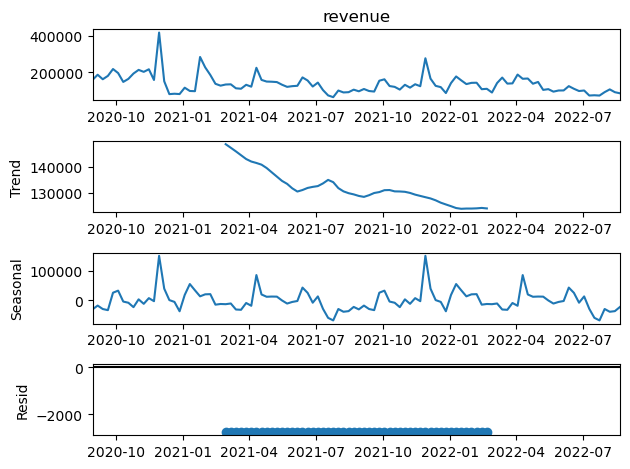

In [56]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['revenue'],model='additive')
resplot = decomposition.plot()

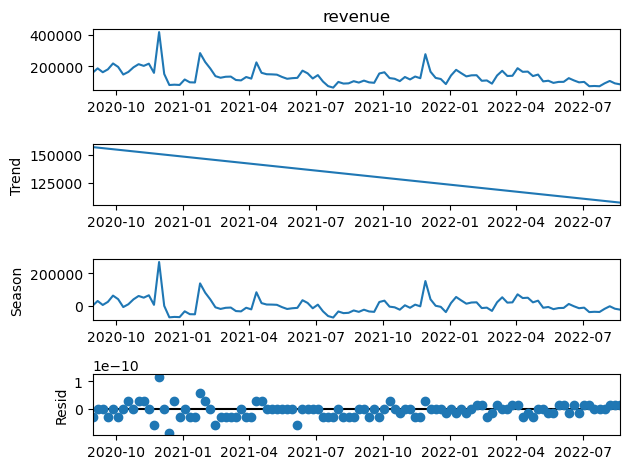

In [58]:
from statsmodels.tsa.seasonal import STL

stl = STL(df['revenue'])
res = stl.fit()
fig = res.plot()


/tmp/ipykernel_369866/3400729263.py:3: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")


<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

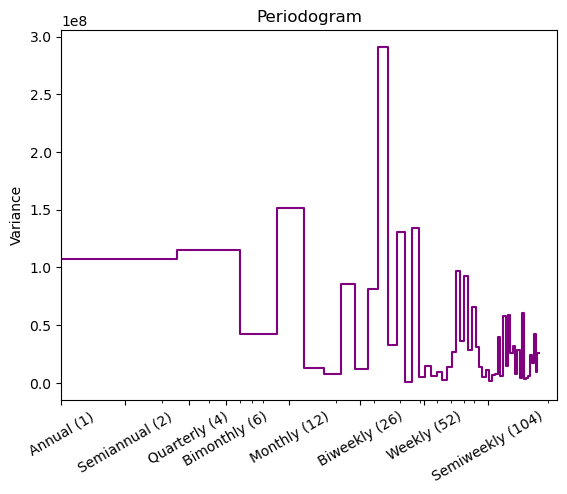

In [43]:
plot_periodogram(df.revenue)

In [49]:
from statsmodels.tsa.stattools import pacf_ols

pacf_ols(df.revenue)

array([ 1.        ,  0.45098196,  0.09793483,  0.02465994,  0.01492149,
        0.02580962, -0.06195144,  0.00735106,  0.38435683,  0.15411098,
       -0.05933931, -0.06248097,  0.0540507 , -0.06277158,  0.08470762,
       -0.01169607, -0.14782994, -0.06716089,  0.01296662,  0.17619246,
       -0.03624028])

In [ ]:
summary_table(df)

In [ ]:
#values for revenue compared the channels differs in scale
df.boxplot()

In [ ]:
rwm = raw.melt('start_of_week',var_name='cols', value_name='vals')
rwm['type']= 'daily'
weekly = rwm.groupby([pd.to_datetime(rwm.start_of_week).dt.week,'cols']).mean().reset_index()
weekly['type']='weekly'
monthly = rwm.groupby([pd.to_datetime(rwm.start_of_week).dt.month,'cols']).mean().reset_index()
monthly['type']='monthly'
df_table= rwm.append(weekly, ignore_index=True).append(monthly,ignore_index=True)


In [ ]:
sns.relplot(data=df_table, x="start_of_week", y="vals", col="type",row='cols',kind="line", facet_kws=dict(sharex=False,sharey=False))

In [ ]:
df['day'] = pd.to_datetime(df.start_of_week).dt.dayofyear
df['week'] = pd.to_datetime(df.start_of_week).dt.week
df['month'] = pd.to_datetime(df.start_of_week).dt.month
df['year'] = pd.to_datetime(df.start_of_week).dt.year

In [ ]:
df

In [ ]:
n_order = 1
periods = df["day"] / 365.25
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)


In [ ]:
fig, ax = plt.subplots(nrows=2, sharex=True, layout="constrained")
fourier_features.filter(like="sin").plot(color="C0", alpha=0.15, ax=ax[0])
ax[0].get_legend().remove()
ax[0].set(title="Fourier Modes (Sin)", xlabel="index (week)")
fourier_features.filter(like="cos").plot(color="C1", alpha=0.15, ax=ax[1])
ax[1].get_legend().remove()
ax[1].set(title="Fourier Modes (Cos)", xlabel="index (week)");

In [ ]:
;

In [42]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [ ]:
def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = df['revenue']
result = seasonal_decompose(series, model='additive')
result.plot()
pyplot.show()

In [ ]:
df.corr()

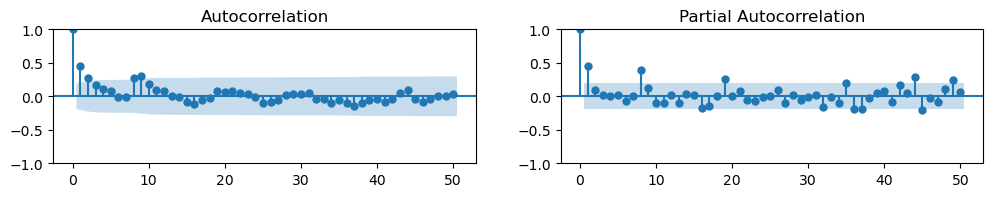

In [53]:
# figure for subplots
plt.figure(figsize = (12, 8))

# acf and pacf for A
plt.subplot(421); plot_acf(df.revenue, lags = 50, ax = plt.gca(),fft=True)
plt.subplot(422); plot_pacf(df.revenue, lags = 50, ax = plt.gca())

plt.show()



In [ ]:
_ = plot_lags(df.revenue, lags=24, nrows=4)

In [ ]:
def lagplot(x, y=None, lag=1, standardize=True, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

In [ ]:
df['week'] = pd.to_datetime(df.start_of_week).dt.day
df['month'] = pd.to_datetime(df.start_of_week).dt.month
df['year'] = pd.to_datetime(df.start_of_week).dt.year


In [ ]:
spend_channels= ['spend_channel_1','spend_channel_2','spend_channel_3','spend_channel_4','spend_channel_5','spend_channel_6','spend_channel_7']
# df['total_spent'] = df[spend_channels].sum(axis=1)

In [ ]:
raw.melt('start_of_week',var_name='cols', value_name='vals')

In [ ]:
rwm = raw.melt('start_of_week',var_name='cols', value_name='vals')


In [ ]:
rwm[rwm['cols']=='revenue']

In [ ]:
rwm.mask(rwm['cols']=='revenue').dropna()

In [ ]:
sns.lineplot(data=rwm.mask(rwm['cols']=='revenue').dropna(), x=pd.to_datetime(rwm.start_of_week).dt.week,y='vals',hue='cols')

In [ ]:
rwm[rwm['cols']=='revenue']

In [ ]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [ ]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample()

In [ ]:
pm.model_to_graphviz(basic_model)

In [ ]:
idata


In [ ]:
az.plot_trace(idata, combined=True);

In [ ]:
az.summary(idata, round_to=2)

In [ ]:
az.plot_energy(idata);

In [ ]:
az.plot_forest(idata, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True);

In [ ]:
spend_channels= ['spend_channel_1','spend_channel_2','spend_channel_3','spend_channel_4','spend_channel_5','spend_channel_6','spend_channel_7']
spends = df[spend_channels].copy()